In [1]:
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error
from scipy.sparse import issparse
from matplotlib import pyplot as plt

%matplotlib inline

import numpy as np
from tqdm import tqdm

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


For ease of comparison, each run of a denoiser at some parameters will be stored in an AnnData object, along with the MCV. A sweep may generate many such objects. Note that the MCV calculation is different than just running the denoiser. These can be done simultaneously, to save memory, but also generated one-by-one, as for scVI.

For a denoised anndata object,

* `X` contains denoised values (in count space)
* `denoiser_name`  names the denoiser
* `denoising_function` is the function itself
* `denoiser_kwargs` are keyword arguments for the denoiser
* `denoiser_model` contains a fitted model if one exists

We stash the MCV:
* `mcv` contains the mcv loss (computed from one or many iterations)

The things needed for comparing methods are:

* `de` contains DE genes for each comparison
* `obsm.cluster` contains output of clustering
* `varm.ggcorr` contains gene-gene correlation matrix

# Function Defs

In [2]:
def split_adata(adata, p=0.5):
    X = adata.raw.X
    if issparse(X):
        X = np.array(X.todense())
    if np.allclose(X, X.astype(np.int)):
        X = X.astype(np.int)
    else:
        raise TypeError("Molecular cross-validation requires integer count data.")

    X1 = np.random.binomial(X, p).astype(np.float)
    X2 = X - X1
    
    adata1 = sc.AnnData(X = X1)
    adata2 = sc.AnnData(X = X2)
    
    return adata1, adata2

In [3]:
def sweep_pca(base_adata, max_pcs = 30, p = 0.9):
    adata = base_adata.copy()
    adata1, adata2 = split_adata(adata, p)

    sc.tl.pca(adata, n_comps=max_pcs, zero_center=False, random_state = 1)
    sc.tl.pca(adata1, n_comps=max_pcs, zero_center=False, random_state = 1)

    k_range = np.concatenate([np.arange(2, 10, 1), np.arange(10, 30, 2), np.arange(30, max_pcs, 5)])
    
    denoised = []
    for i, k in enumerate(tqdm(k_range)):
        reconstruction = adata.obsm['X_pca'][:,:k].dot(adata.varm['PCs'].T[:k])
        reconstruction = np.maximum(reconstruction, 0)
        
        reconstruction1 = adata1.obsm['X_pca'][:,:k].dot(adata1.varm['PCs'].T[:k])
        mcv = mean_squared_error(reconstruction1*(1-p)/p, adata2.X)
        
        adata_denoised = sc.AnnData(X = reconstruction,
                           uns = {'denoiser': 'pca',
                                  'denoiser_param': k,
                                  'denoiser_model': None,
                                  'mcv': mcv
                                  },
                            obs = base_adata.obs)
        denoised.append(adata_denoised)
    return denoised

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd


# Helper function for the diffusion denoiser, computes the diffusion operator
# as a lazy walk over a k-nearest-neighbors graph of the data in PC space.
def compute_diff_op(
    umis: np.ndarray,
    n_components: int = 30,
    n_neighbors: int = 10,
    tr_prob: float = 0.5,
):
    n_counts = np.median(umis.sum(axis=1))

    x1_norm = np.sqrt(umis / umis.sum(axis=1, keepdims=True) * n_counts)

    U, S, V = randomized_svd(x1_norm, n_components)

    p = U.dot(np.diag(S))

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(p)

    diff_op = np.array(nbrs.kneighbors_graph(p, mode="connectivity").todense())
    diff_op += diff_op.T
    diff_op = diff_op / diff_op.sum(axis=1, keepdims=True)
    diff_op = tr_prob * diff_op + (1 - tr_prob) * np.eye(diff_op.shape[0])

    return diff_op

# Diffuse gene values using a lazy walk over a kNN graph. First,
# calculates a kNN graph in PC space and uses that to define a diffusion
# operator. Next, iteratively smoothes the input data according to the
# operator, and returns the result.
def gene_diffusion(umis: np.ndarray, time_steps: int, **diff_op_kwargs):
    # calculate the diffusion operator, e.g. a weighting over a kNN graph
    diff_op = compute_diff_op(umis, **diff_op_kwargs)
    diffused_umis = umis.copy().astype(np.float)

    # perform diffusion over the knn graph
    for t in range(time_steps):
        diffused_umis = diff_op.dot(diffused_umis)

    return diffused_umis

def poisson_nll_loss(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    return (y_pred - y_true * np.log(y_pred + 1e-6)).mean()

def sweep_diffusion(base_adata, max_t = 10, p = 0.9):
    adata = base_adata.copy()
    adata1, adata2 = split_adata(adata, p)

    diff_op = compute_diff_op(adata.X)
    diff_op1 = compute_diff_op(adata1.X)
    
    diffused_umis = adata.X.copy().astype(np.float)
    diffused_umis1 = adata1.X.copy().astype(np.float)

    t_range = np.arange(max_t)
    
    denoised = []
    for i, t in enumerate(tqdm(t_range)):
        
        diffused_umis = diff_op.dot(diffused_umis)
        diffused_umis1 = diff_op1.dot(diffused_umis1)
        
        mcv = poisson_nll_loss(diffused_umis1*(1-p)/p, adata2.X)
        
        adata_denoised = sc.AnnData(X = diffused_umis,
                           uns = {'denoiser': 'diffusion',
                                  'denoiser_param': t,
                                  'denoiser_model': None,
                                  'mcv': mcv
                                  },
                            obs = base_adata.obs)
        denoised.append(adata_denoised)
    return denoised

In [5]:
# def sweep_pca_sqrt(base_adata, max_pcs = 30, p = 0.9, n_iter = 1):
#     adata = base_adata.copy()
#     adata1, adata2 = split_adata(adata, p)

#     X = adata.X
#     X1 = adata.X1
#     sc.tl.pca(adata, n_comps=max_pcs, zero_center=False, random_state = 1)
#     sc.tl.pca(adata1, n_comps=max_pcs, zero_center=False, random_state = 1)

#     k_range = np.concatenate([np.arange(2, 10, 1), np.arange(10, 30, 2), np.arange(30, max_pcs, 5)])
    
#     denoised = []
#     for i, k in enumerate(tqdm(k_range)):
#         reconstruction = adata.obsm['X_pca'][:,:k].dot(adata.varm['PCs'].T[:k])
        
#         reconstruction1 = adata1.obsm['X_pca'][:,:k].dot(adata1.varm['PCs'].T[:k])
#         mcv = mean_squared_error(reconstruction1*(1-p)/p, adata2.X)
        
#         adata_denoised = sc.AnnData(X = reconstruction,
#                            uns = {'denoiser': 'pca',
#                                   'denoiser_param': k,
#                                   'denoiser_model': None,
#                                   'mcv': mcv
#                                   })
#         denoised.append(adata_denoised)
#     return denoised

In [6]:
def compute_gt_mse(adata_denoised, adata):
    X_true = adata.obsm['X_true']
    X = adata_denoised.X
    
    X_true = X_true*(X.sum(1, keepdims = True)/X_true.sum(1, keepdims = True))
    adata_denoised.uns['gt_mse'] = mean_squared_error(X, X_true)

In [7]:
def compute_gt_poisson(adata_denoised, adata):
    X_true = adata.obsm['X_true']
    X = adata_denoised.X
    
    X_true = X_true*(X.sum(1, keepdims = True)/X_true.sum(1, keepdims = True))
    adata_denoised.uns['gt_poisson'] = poisson_nll_loss(X, X_true)

In [8]:
def gene_gene_corr(adata, mat_key = None, sqrt = False):
    X = adata.X
    if sqrt:
        X = np.sqrt(X)
    if mat_key:
        X = adata.obsm[mat_key]
    corr = np.corrcoef(X, rowvar=False)
    corr = np.nan_to_num(corr)
    adata.varm['ggcorr'] = corr
    
def corr_mat_dist(cor1, cor2):
    return 1 - np.trace(cor1.dot(cor2))/np.sqrt(np.trace(cor1.dot(cor1))*np.trace(cor2.dot(cor2)))
    
def gene_gene_corr_eb(adata, mat_key = None):
    """For count data, the covariances are overdispersed."""
    X = adata.X
    if mat_key:
        X = adata.obsm[mat_key]
    
    cov = np.cov(X, rowvar=False)
    means = np.mean(X, axis = 0)
    
    var_adjusted = np.diag(cov) - means
    cov_adjusted = cov - np.diag(means)
    
    # Don't adjust if it's too small
    var_adjusted = np.maximum(var_adjusted, cov_adjusted.max(axis = 0))

    cov_adjusted = cov - np.diag(np.diag(cov)) + np.diag(var_adjusted) + 1e-6
    assert np.all(np.diag(cov_adjusted) > 0)
    
    corr = cov_adjusted / (np.sqrt(var_adjusted[:,np.newaxis] * var_adjusted[np.newaxis, :]))
    
    adata.varm['ggcorr_eb'] = corr

In [9]:
def compute_cluster(adata, sqrt=True, n_comps = 100, n_neighbors = 10, target_n_clusters = None):
    X = adata.X.copy()
    if sqrt:
        sc.pp.sqrt(adata)
    sc.tl.pca(adata, n_comps=n_comps, zero_center=False)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors)
    resolution = 1
    
    sc.tl.leiden(adata, resolution = resolution)
    if target_n_clusters:
        while True:
            n_clusters = len(np.unique(adata.obs['leiden']))
            if n_clusters < target_n_clusters:
                resolution = resolution * 1.1
                sc.tl.leiden(adata, resolution = resolution)
            elif n_clusters > target_n_clusters*1.5:
                resolution = resolution * 0.9
                sc.tl.leiden(adata, resolution = resolution)
            else:
                break
    sc.tl.umap(adata)
    adata.uns['n_clusters'] = len(np.unique(adata.obs['leiden']))
    
    # restore original values of X
    adata.X = X

In [10]:
from sklearn.metrics import adjusted_rand_score

def clust_to_label(clusters, labels):
    "Given a clustering and a labeling, map each cluster to its most frequent label."
    ct = pd.crosstab(clusters, labels)
    consensus_label = np.argmax(pd.crosstab(clusters, labels).values, axis = 1)
    remapper = dict(zip(ct.index, ct.columns[consensus_label]))
    new_labels = clusters.map(remapper)
    return new_labels

def induced_label_ari(clusters, labels):
    return adjusted_rand_score(clust_to_label(clusters, labels), labels)

def print_aris(adata, ref_key, keys):
    for key in ['leiden']:
        ari = adjusted_rand_score(adata.obs[key], adata.obs[ref_key])
        induced_ari = induced_label_ari(adata.obs[key], adata.obs[ref_key])
        print(f'{key}\tInduced ARI: {induced_ari:.2}\tARI: {ari:.2}\tN Clusters:{len(adata.obs[key].unique())}')

In [11]:
def compute_ari(adata_denoised, adata, key):
    adata_denoised.uns['ari'] = induced_label_ari(adata_denoised.obs['leiden'], adata.obs[key])

In [12]:
def extract_best(denoised):
    best_mcv = np.inf
    best_adata = None
    
    for adata in denoised:
        if best_mcv > adata.uns['mcv']:
            best_mcv = adata.uns['mcv']
            best_adata = adata
    return best_adata

In [13]:
def plot_scalar(denoised, field):
    params = []
    values = []
    
    for adata in denoised:
        params.append(adata.uns['denoiser_param'])
        values.append(adata.uns[field])
    plt.plot(params, values)

# Do it

In [14]:
symsim = sc.read('../data/symsim/symsim.h5ad')
symsim.raw = symsim

In [15]:
denoised = sweep_pca(symsim, max_pcs = 50)

100%|██████████| 22/22 [00:00<00:00, 118.47it/s]


In [16]:
# Compute ground-truth error
for adata in denoised:
    compute_gt_mse(adata, symsim)

In [17]:
# Compute gene gene correlations
gene_gene_corr(symsim, mat_key = 'X_true')

for adata in denoised:
    gene_gene_corr(adata)
    adata.uns['ggcorr_error'] = corr_mat_dist(adata.varm['ggcorr'], symsim.varm['ggcorr'])

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [18]:
# Compute clustering and ari
for adata in denoised:
    compute_cluster(adata, target_n_clusters=5)
    compute_ari(adata, symsim, 'pop')

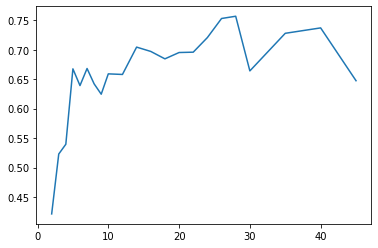

In [19]:
plot_scalar(denoised, 'ari')

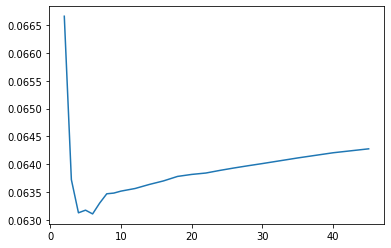

In [20]:
plot_scalar(denoised, 'mcv')

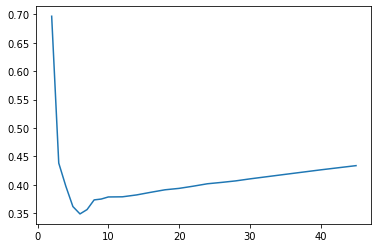

In [21]:
plot_scalar(denoised, 'gt_mse')

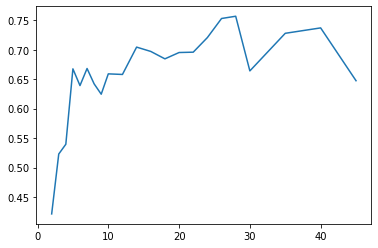

In [22]:
plot_scalar(denoised, 'ari')

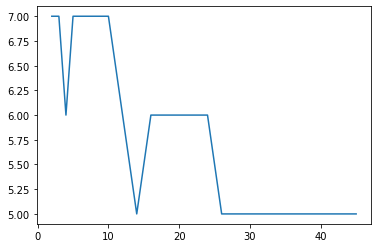

In [23]:
plot_scalar(denoised, 'n_clusters')

In [24]:
best_denoised = extract_best(denoised)

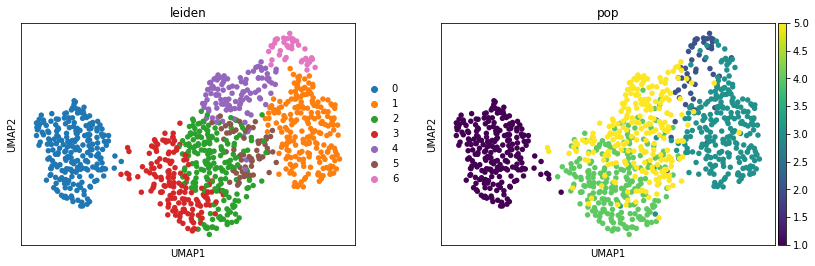

In [25]:
sc.pl.umap(best_denoised, color=['leiden', 'pop'])

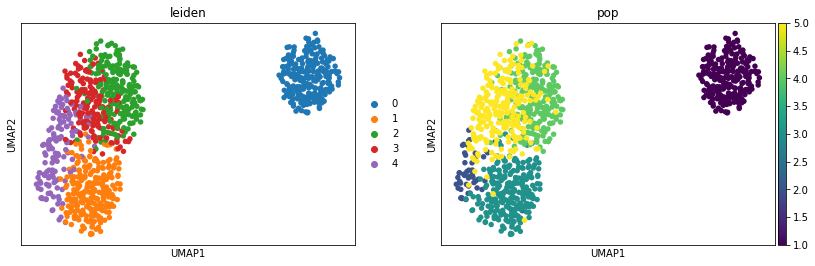

In [26]:
sc.pl.umap(denoised[-1], color=['leiden', 'pop'])

# Diffusion

In [27]:
symsim = sc.read('../data/symsim/symsim.h5ad')
symsim.raw = symsim

In [28]:
denoised = sweep_diffusion(symsim, max_t = 30)

100%|██████████| 30/30 [00:01<00:00, 26.84it/s]


In [29]:
# Compute ground-truth error
for adata in denoised:
    compute_gt_poisson(adata, symsim)

In [30]:
# Compute gene gene correlations
gene_gene_corr(symsim, mat_key = 'X_true', sqrt = True)

for adata in denoised:
    gene_gene_corr(adata, sqrt = True)
    adata.uns['ggcorr_error'] = corr_mat_dist(adata.varm['ggcorr'], symsim.varm['ggcorr'])

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
# Compute clustering and ari
for adata in denoised:
    compute_cluster(adata, target_n_clusters=5)
    compute_ari(adata, symsim, 'pop')

In [ ]:
plot_scalar(denoised, 'mcv')

In [ ]:
plot_scalar(denoised, 'gt_poisson')

In [ ]:
plot_scalar(denoised, 'ggcorr_error')

In [ ]:
plot_scalar(denoised, 'ari')

In [ ]:
plot_scalar(denoised, 'n_clusters')

In [ ]:
best_denoised = extract_best(denoised)

In [ ]:
sc.pl.umap(best_denoised, color=['leiden', 'pop'])

In [ ]:
sc.pl.umap(denoised[-1], color=['leiden', 'pop'])

ARI from ground-truth

In [ ]:
symsim_gt = symsim.copy()
symsim_gt.X = symsim.obsm['X_true']
compute_cluster(symsim_gt)
compute_ari(symsim_gt, symsim, 'pop')
print(symsim_gt.uns['ari'])

In [ ]:
sc.pl.umap(symsim_gt, color=['leiden', 'pop'])

# Visualizing gene correlations

In [ ]:
import seaborn as sns

In [ ]:
sns.clustermap(symsim.varm['ggcorr'], cmap = 'bwr', vmin = -1, vmax = 1)

In [ ]:
sns.clustermap(best_denoised.varm['ggcorr'], cmap = 'bwr', vmin = -1, vmax = 1)